90
MEAN :  -73.56802329130029 45.511132381741284
42 42


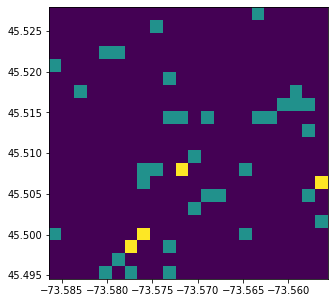

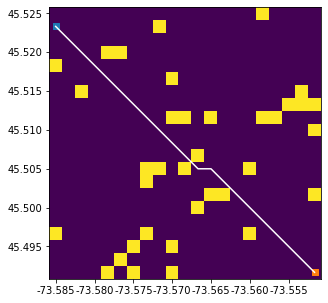

Time - taken : 4.298616647720337


In [21]:
import geopandas as gp
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point,Polygon,MultiPolygon
from shapely.ops import nearest_points
import seaborn as sns
import math 
import sys
import heapq
%matplotlib inline
import _locale
_locale._getdefaultlocale = (lambda *args: ['en_US', 'utf8'])
import time
import matplotlib.ticker as plticker



def showMap():
    shape = gp.read_file("D:\Shape\crime_dt.shp")
    path = "D:\Shape\crime_dt.shp"
    test = GeoDataFrame.from_file(path,encoding='latin-1')
    sf = shp.Reader(path,encoding='latin-1')

    points = test['geometry']
    xA = np.array(test['geometry'].x)
    yA = np.array(test['geometry'].y)
    
    
    
    xMin, xMax, yMin, yMax = -73.59,-73.55,45.49,45.53
    noOfRows = math.ceil((xMax - xMin)/0.002)
    noOfColumns = math.ceil((yMax - yMin)/0.002)  
    
    parseShow = np.array([[0]*21]*21)
#     for i in range(20):
#         for j in range(20):
#             parseShow[i][j] = 1
    
#     fig, ax = plt.subplots(figsize=(5,5))
#     ax.imshow(parseShow)
    
    
    plot1 = np.array([])
    plot = np.array([])
    weights = np.array([])
    
    threshold = 90
    if threshold == 50 or threshold == 75 or threshold == 90:
        calculateThreshold(points,xA,yA,threshold)   
    else:
        fig_size = [6,6]
        plt.rcParams["figure.figsize"] = fig_size
        l = plt.hist2d(xA,yA,bins=(noOfRows+1,noOfColumns+1))
   
#     start = time.time()
#     calculateThreshold(points,xA,yA,80)

    
def heuristicFunction(a, b):
    value =  np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    return value
    
def pathFinder(array, start, end):
    
    value = []
    status = False
    directions = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    fn = {start:heuristicFunction(start, end)}
    shortestPath = []
    positions = set()
    pathDict = {}
    gn = {start:0}
    heapq.heappush(shortestPath, (fn[start], start))
    pathcalulate(array,start,end,value,status,directions,fn,shortestPath,positions,pathDict,gn,heapq)
    

def pathcalulate(array,start,end,value,status,directions,fn,shortestPath,positions,pathDict,gn,heapq):
    
 
    while shortestPath:

        current = heapq.heappop(shortestPath)[1]

        if current == end:
            
            while current in pathDict:
                value.append(current)
                current = pathDict[current]
            return value

        positions.add(current)
        for i, j in directions:
            adjacent = current[0] + i, current[1] + j
            temp_g = gn[current] + heuristicFunction(current, adjacent)
            if 0 <= adjacent[0] < array.shape[0]:
                if 0 <= adjacent[1] < array.shape[1]:                
                    if array[adjacent[0]][adjacent[1]] == 1:
                        continue
                else:
                    
                    continue  # out of bound for Y axis
            else:
                
                continue  # out of bound for X axis
                 
            if adjacent in positions and temp_g >= gn.get(adjacent, 0):
                continue
                
            if  temp_g < gn.get(adjacent, 0) or adjacent not in [i[1]for i in shortestPath]:
                pathDict[adjacent] = current
                gn[adjacent] = temp_g
                fn[adjacent] = temp_g + heuristicFunction(adjacent, end)
                heapq.heappush(shortestPath, (fn[adjacent], adjacent))
                
#     print("F(n) :",fn)
                
    return value

#proper calculation of threshold is left !    
def calculateThreshold(points,xA,yA,threshold):
    
    print(threshold)
    xMin, xMax, yMin, yMax = -73.59,-73.55,45.49,45.53
    noOfRows = math.ceil((xMax - xMin)/0.002)
    noOfColumns = math.ceil((yMax - yMin)/0.002)  
    
    crimeDict = {}
    
    for i in range(len(points)):
        k = xA[i],yA[i]
        if k in crimeDict.keys():
            crimeDict[xA[i],yA[i]]  = crimeDict[xA[i],yA[i]] + 1  
        else:
            crimeDict[xA[i],yA[i]] = 1
        
    threshold50 = 50
    threshold75 = 75
    threshold90 = 90
    
    listX = np.array([])
    listY = np.array([])
    weights = np.array([])
    

#     crimeDict = dict(sorted(crimeDict.items(), key=lambda kv: kv[1], reverse=True))
#     print(crimeDict.items())
    
    
    
    xAA = []
    yAA = []
    
    for i,j in dict(sorted(crimeDict.items(), key=lambda kv: kv[1], reverse=True)).keys():
        xAA = np.append(xAA,i)
        yAA = np.append(yAA,j)
        
        
    lat = []
    long = []
    
    x = sum(xAA)/len(xAA)
    y = sum(yAA)/len(yAA)
    
    print("MEAN : ", x,y)
    
    
    if threshold == 50:
        for i in range(int((noOfRows*noOfColumns)*(50/100))):
                listX = np.append(listX,xAA[i])
                listY = np.append(listY,yAA[i])
        fig_size = [5,5]
        plt.rcParams["figure.figsize"] = fig_size
        l = plt.hist2d(listX,listY,bins=(noOfRows+1,noOfColumns+1))
    
    if threshold == 75:
        for i in range(int((noOfRows*noOfColumns)*(15/100))):
            listX = np.append(listX,xAA[i])
            listY = np.append(listY,yAA[i])
        fig_size = [5,5]
        plt.rcParams["figure.figsize"] = fig_size
        l = plt.hist2d(listX,listY,bins=(noOfRows+1,noOfColumns+1))
    
    elif threshold == 90:
        for i in range(int((noOfRows*noOfColumns)*(10/100))):
            listX = np.append(listX,xAA[i])
            listY = np.append(listY,yAA[i])
        fig_size = [5,5]
        plt.rcParams["figure.figsize"] = fig_size
        l = plt.hist2d(listX,listY,bins=(noOfRows+1,noOfColumns+1))
    
            
    print(len(listX),len(listY))
    
    length = (len(l[0]))
#     print("Length : ",length)
    
    parse = np.array([[0]*21]*21)
    
    
    for i in range(0,length-1):
        for j in range(0,length-1):
            if l[0][i][j] > 0:
                parse[i][j] = 1 
            else:
                parse[i][j] = 0
    
#     print(parse)
#     parse = parse[::-1]
    parse = parse.transpose()
    parse = parse[::-1]
    start =(20,20)
    goal = (1,0)
    
    value = []
    status = False
    directions = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    fn = {start:heuristicFunction(start, goal)}
    shortestPath = []
    positions = set()
    pathDict = {}
    gn = {start:0}
    heapq.heappush(shortestPath, (fn[start], start))
    
  
#     solutionPath = pathFinder(parse, start, goal)
    solutionPath = pathcalulate(parse,start,goal,value,status,directions,fn,shortestPath,positions,pathDict,gn,heapq)
    
#     print(solutionPath)
    solutionPath = solutionPath + [start]
    solutionPath = solutionPath[::-1]
    
    
    x_coords = []
    y_coords = []

    for i in (range(0,len(solutionPath))):
        x = solutionPath[i][0]
        y = solutionPath[i][1]
        x_coords.append(x)
        y_coords.append(y)
    
     
    # plot map and path
    if parse[start] == 1 or parse[goal] == 1:
        print("ROUTE CANNOT BE TRAVERSED !")
        fig, ax2 = plt.subplots(figsize=(5,5))
        ax2.imshow(parse)
        labels = [item.get_text() for item in ax2.get_xticklabels()]
        labelsy = [item.get_text() for item in ax2.get_yticklabels()]
            
            
#             plt.xticks(np.arange(1, 7, 3))
        loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
        ax2.xaxis.set_major_locator(loc)
        ax2.yaxis.set_major_locator(loc)
        lll =['-73.585','-73.580','-73.575','-73.570','-73.565','-73.560','-73.555']
        labels[1] = lll[0]
        labels[2] = lll[1]
        labels[3] = lll[2]
        labels[4] = lll[3]
        labels[5] = lll[4]
        labels[6] = lll[5]
        labels[7] = lll[6]
        ax2.set_xticklabels(labels)
            
        lly=['45.495','45.500','45.505','45.510','45.515','45.520','45.525']
            
        labelsy[1] = lly[6]
        labelsy[2] = lly[5]
        labelsy[3] = lly[4]
        labelsy[4] = lly[3]
        labelsy[5] = lly[2]
        labelsy[6] = lly[1]
        labelsy[7] = lly[0]
        ax2.set_yticklabels(labelsy)
      
#         l = plt.hist2d(listX,listY,bins=(noOfRows+1,noOfColumns+1))
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(parse)
    
        if threshold == 50 or threshold == 75 or threshold == 90:
            ax.scatter(goal[1],goal[0], marker = 's')
            ax.scatter(start[1],start[0], marker = 's')
            ax.plot(y_coords,x_coords, color = "white")
            labels = [item.get_text() for item in ax.get_xticklabels()]
            labelsy = [item.get_text() for item in ax.get_yticklabels()]
            
            
#             plt.xticks(np.arange(1, 7, 3))
            loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
            ax.xaxis.set_major_locator(loc)
            ax.yaxis.set_major_locator(loc)
            lll =['-73.585','-73.580','-73.575','-73.570','-73.565','-73.560','-73.555']
            labels[1] = lll[0]
            labels[2] = lll[1]
            labels[3] = lll[2]
            labels[4] = lll[3]
            labels[5] = lll[4]
            labels[6] = lll[5]
            labels[7] = lll[6]
            ax.set_xticklabels(labels)
            
            lly=['45.495','45.500','45.505','45.510','45.515','45.520','45.525']
            
            labelsy[1] = lly[6]
            labelsy[2] = lly[5]
            labelsy[3] = lly[4]
            labelsy[4] = lly[3]
            labelsy[5] = lly[2]
            labelsy[6] = lly[1]
            labelsy[7] = lly[0]
            ax.set_yticklabels(labelsy)
            
            
            plt.show()  
        else:
            print(threshold)
    
start = time.time()
showMap()
end = time.time()
print("Time - taken :", end - start)